# モデル選択

## 自由エネルギー
周辺尤度の対数の符号を逆転させたものを（逆温度1の）「自由エネルギー(free energy)」といって$F_n$で表す．
$$
F_n= −\log p(X^n)= −\log \int p(X^n|\theta)\phi(\theta)d\theta
$$
自由エネルギー$F_n$の$X^n$についての平均は，真の分布のエントロピーのn倍と真の分布と周辺尤度の（$X^n$についての）カルバック=ライブラ(KL)距離に分解できる（渡辺 2012: 8-9）．
$$
E_{X^n}[F_n]=−n\int q(x)\log q(x) dx + \int q(x^n) \log \frac{q(x^n)}{p(x^n)}dx^n
$$
真の分布のエントロピーは変わらないとすると，真の分布と周辺尤度の平均的な遠さを表すKL距離が小さくなるほど，自由エネルギーの平均は小さくなる．そこで，自由エネルギーが小さくなるほど周辺尤度がよく真の分布を近似していると言えるだろう．

## WBIC
正則でないモデルにおいても，自由エネルギーの近似値を導出できるのが「WBIC(Watanabe Widely Applicable Bayesian Information Criterion)」である(Watanabe 2013，「広く使えるベイズ情報量規準(WBIC)」)．これは，逆温度が$\beta=1/\log n$のときの事後分布によって，
対数損失$L_n(\theta)=−1\sum_i\log p(x_i|\theta)$のn倍について期待値をとったものとして定義される．
$${\rm WBIC} = \frac{\int n L_n (\theta) \Pi_i p(x_i|\theta)^\beta \phi(\theta)d\theta}{\int \Pi_i p(x_i|\theta)^\beta \phi(\theta)d\theta}$$
このとき自由エネルギー$F_n$とWBICは$\log n$
のオーダーまで同じ漸近挙動をもつ．

つまり、真のモデルを当てたいときはWBICが使える.

モデルのパラメタを$\theta$として、$\theta$ が与えられた時の対数損失のn倍(nはデータサンプルサイズ): $-\log p(X^i|\theta_s)$の事後分布における期待値がWBICとなる。
事後分布における期待値は、MCMCによって事後分布サンプルが得られている場合、事後分布から得られた$\theta_s$(sはMCMCのサンプルインデックス)の場合の対数損失の平均値を計算すればいい。
$$
\begin{align}
{\rm WBIC} &=& \mathbb{E}^{1/logN}_\theta [-\log(p(X^n|\theta))] \\
{\rm WBIC_{mcmc}} &=& \frac{1}{S}\sum^{S}_{s=1} \sum^{n}_{i=1} -\log(p(X^i|\theta_s))
\end{align}
$$

例えば、回帰問題の場合$p(X^i,Y^i|\theta)$は、よく使う尤度として
$$p(Y^i, X^i|\theta) = \mathcal{N}(f_\phi(X^i)-Y^i, \sigma), \theta=\{\phi, \sigma\}$$
が使われる

WBICを実際に計算してみる

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import pandas as pd
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as random

import numpyro

numpyroによるMCMCを用いてWBICを計算する

In [11]:
def model(x, y, y_obs, N=100):
    ## 回帰係数 a、切片項 b の事前分布に平均0, 分散100の正規分布を置きます。
    a = numpyro.sample("a", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    b = numpyro.sample("b", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    ## 分散パラメータ sigma の事前分布に平均0, 分散10の対数正規分布を置きます。
    sigma = numpyro.sample("sigma", numpyro.distributions.LogNormal(0, 10))
    log_likelihood = numpyro.distributions.Normal(a*x+b, sigma).log_prob(y).sum()
    numpyro.deterministic('log_lik', log_likelihood)
    ## 観測についての確率モデルとして、正規分布を置きます。
    ## yは実際に観測されているものなので、データyと観測モデルを紐づけるために、obs=yと設定しておきます
    with numpyro.plate("data", N):
        numpyro.sample("obs", numpyro.distributions.Normal(a*x + b, sigma), obs=y_obs)

データを作ってMCMCを用いて事後分布を計算しながらフィットする

Text(0.5, 1.0, 'N=20')

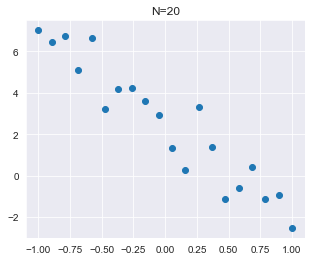

In [44]:
def toy_data(a ,b ,N):
    x = np.linspace(-1,1,N)
    y = a * x + b  + 1.0*jax.random.normal(jax.random.PRNGKey(1), x.shape)
    return x, y

x_data, y_data = toy_data(-5, 3, 20)
fig, ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(5,4))
ax.plot(x_data, y_data, "o")
ax.set_title("N=20")

In [18]:
kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=300, num_samples=1000)

In [19]:
mcmc.run(jax.random.PRNGKey(1),x = x_data, y = y_data, y_obs=y_data, N = x_data.shape[0])

sample: 100%|██████████| 1300/1300 [00:07<00:00, 168.64it/s, 3 steps of size 8.02e-01. acc. prob=0.87]


In [20]:
# それぞれの事後分布サンプルを得る
samples = mcmc.get_samples()
a_samples = samples["a"].squeeze()
b_samples = samples["b"].squeeze()
sigma_samples = samples["sigma"].squeeze()

Text(0.5, 0.98, 'posterior of sigma')

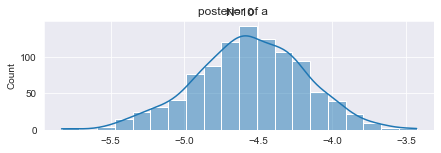

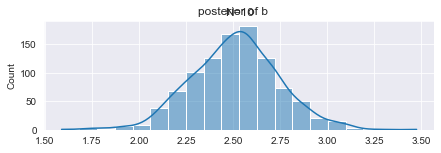

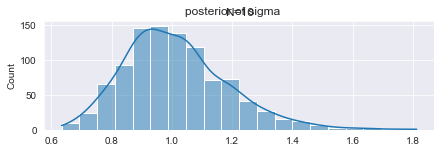

In [21]:
##aについて
fig1, ax1 = plt.subplots(1,1,figsize=(7,2),sharey=True,sharex=True)
sns.histplot(a_samples, kde=True, bins=20, ax=ax1).set_title("N=10")
fig1.suptitle("posterior of a")
##bについて
fig2, ax2 = plt.subplots(1,1,figsize=(7,2),sharey=True,sharex=True)
sns.histplot(b_samples, kde=True, bins=20, ax=ax2).set_title("N=10")
fig2.suptitle("posterior of b")
##sigmaについて
fig3, ax3 = plt.subplots(1,1,figsize=(7,2),sharey=True,sharex=True)
sns.histplot(sigma_samples, kde=True, bins=20, ax=ax3).set_title("N=10")
fig3.suptitle("posterior of sigma")

WBICを計算

In [22]:
def calc_wbic(samples, x_data, y_data):
    log_lik = []
    for a,b,sig in zip(samples['a'], samples['b'], samples['sigma']):
        log_lik.append(-numpyro.distributions.Normal(loc=a*x_data+b, scale=sig).log_prob(y_data).sum())
    return np.mean(log_lik)

In [24]:
calc_wbic(samples, x_data, y_data)

28.436272

In [29]:
# モデルの中で定義したlog_likelihoodからも計算で
np.mean(-samples['log_lik'])

DeviceArray(28.436275, dtype=float32)

Fitting結果の可視

In [26]:
from numpyro.infer import Predictive
predictive = Predictive(model, samples)

In [27]:
predict_samples = predictive(random.PRNGKey(0), x=x_data, y=y_data, y_obs=None, N=20)

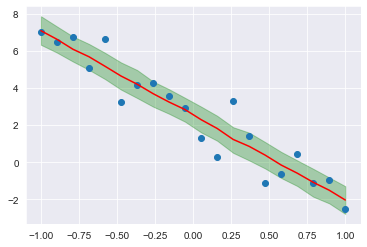

In [28]:
mean = predict_samples['obs'].mean(axis=0)
low, high = jnp.percentile(predict_samples['obs'], jnp.array([25,75]), axis=0)
plt.plot(x_data10, y_data10, "o")
plt.plot(x_data10, mean, "r")
plt.fill_between(x_data10, y1=low, y2=high, color='g', alpha=0.3)
#plt.fill_between(x_data10, low, high, "r", alpha=0.3)

### WBICによるモデル選択

2次関数から生成したデータに対して、4つのモデルを用意して、正しく2次関数のモデルが選択されるかテストする

In [30]:
def model1(x, y, y_obs, N=100):
    ## 回帰係数 a、切片項 b の事前分布に平均0, 分散100の正規分布を置きます。
    a = numpyro.sample("a", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    b = numpyro.sample("b", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    ## 分散パラメータ sigma の事前分布に平均0, 分散10の対数正規分布を置きます。
    sigma = numpyro.sample("sigma", numpyro.distributions.LogNormal(0, 10))
    log_likelihood = numpyro.distributions.Normal(a*x+b, sigma).log_prob(y).sum()
    numpyro.deterministic('log_lik', log_likelihood)
    ## 観測についての確率モデルとして、正規分布を置きます。
    ## yは実際に観測されているものなので、データyと観測モデルを紐づけるために、obs=yと設定しておきます
    with numpyro.plate("data", N):
        numpyro.sample("obs", numpyro.distributions.Normal(a*x + b, sigma), obs=y_obs)

def model2(x, y, y_obs, N=100):
    ## 回帰係数 a、切片項 b の事前分布に平均0, 分散100の正規分布を置きます。
    a = numpyro.sample("a", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    b = numpyro.sample("b", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    c = numpyro.sample("c", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    ## 分散パラメータ sigma の事前分布に平均0, 分散10の対数正規分布を置きます。
    sigma = numpyro.sample("sigma", numpyro.distributions.LogNormal(0, 10))
    log_likelihood = numpyro.distributions.Normal(a*(x**2)+b*x+c, sigma).log_prob(y).sum()
    numpyro.deterministic('log_lik', log_likelihood)
    ## 観測についての確率モデルとして、正規分布を置きます。
    ## yは実際に観測されているものなので、データyと観測モデルを紐づけるために、obs=yと設定しておきます
    with numpyro.plate("data", N):
        numpyro.sample("obs", numpyro.distributions.Normal(a*(x**2)+b*x+c, sigma), obs=y_obs)

def model3(x, y, y_obs, N=100):
    ## 回帰係数 a、切片項 b の事前分布に平均0, 分散100の正規分布を置きます。
    a = numpyro.sample("a", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    b = numpyro.sample("b", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    c = numpyro.sample("c", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    d = numpyro.sample("d", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    ## 分散パラメータ sigma の事前分布に平均0, 分散10の対数正規分布を置きます。
    sigma = numpyro.sample("sigma", numpyro.distributions.LogNormal(0, 10))
    log_likelihood = numpyro.distributions.Normal( a*(x**3)+ b*(x**2)+c*x+d, sigma).log_prob(y).sum()
    numpyro.deterministic('log_lik', log_likelihood)
    ## 観測についての確率モデルとして、正規分布を置きます。
    ## yは実際に観測されているものなので、データyと観測モデルを紐づけるために、obs=yと設定しておきます
    with numpyro.plate("data", N):
        numpyro.sample("obs", numpyro.distributions.Normal(a*(x**3)+ b*(x**2)+c*x+d, sigma), obs=y_obs)

def model4(x, y, y_obs, N=100):
    ## 回帰係数 a、切片項 b の事前分布に平均0, 分散100の正規分布を置きます。
    a = numpyro.sample("a", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    b = numpyro.sample("b", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    c = numpyro.sample("c", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    d = numpyro.sample("d", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    e = numpyro.sample("e", numpyro.distributions.Normal(loc=jnp.array(0.), scale=jnp.array(100.)))
    ## 分散パラメータ sigma の事前分布に平均0, 分散10の対数正規分布を置きます。
    sigma = numpyro.sample("sigma", numpyro.distributions.LogNormal(0, 10))
    log_likelihood = numpyro.distributions.Normal( a*(x**4)+ b*(x**3)+c*(x**2)+d*x+e, sigma).log_prob(y).sum()
    numpyro.deterministic('log_lik', log_likelihood)
    ## 観測についての確率モデルとして、正規分布を置きます。
    ## yは実際に観測されているものなので、データyと観測モデルを紐づけるために、obs=yと設定しておきます
    with numpyro.plate("data", N):
        numpyro.sample("obs", numpyro.distributions.Normal(a*(x**4)+ b*(x**3)+c*(x**2)+d*x+e, sigma), obs=y_obs)

Text(0.5, 1.0, 'N=10')

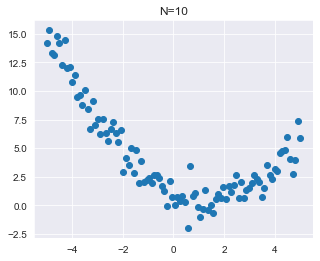

In [43]:
def toy_data(a , b, c ,N):
    x = np.linspace(-5,5,N)
    y = a * x**2 + b*x + c  + 1.0*jax.random.normal(jax.random.PRNGKey(1), x.shape)
    return x, y
x_data10, y_data10 = toy_data(0.4, -1, 1, 100)
fig, ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(5,4))
ax.plot(x_data10, y_data10, "o")
ax.set_title("N=10")

In [32]:
kernel = numpyro.infer.NUTS(model1)
mcmc1 = numpyro.infer.MCMC(kernel, num_warmup=300, num_samples=1000)
mcmc1.run(jax.random.PRNGKey(1),x = x_data10, y = y_data10, y_obs=y_data10, N = x_data10.shape[0])
kernel = numpyro.infer.NUTS(model2)
mcmc2 = numpyro.infer.MCMC(kernel, num_warmup=300, num_samples=1000)
mcmc2.run(jax.random.PRNGKey(1),x = x_data10, y = y_data10, y_obs=y_data10, N = x_data10.shape[0])
kernel = numpyro.infer.NUTS(model3)
mcmc3 = numpyro.infer.MCMC(kernel, num_warmup=300, num_samples=1000)
mcmc3.run(jax.random.PRNGKey(1),x = x_data10, y = y_data10, y_obs=y_data10, N = x_data10.shape[0])
kernel = numpyro.infer.NUTS(model4)
mcmc4 = numpyro.infer.MCMC(kernel, num_warmup=300, num_samples=1000)
mcmc4.run(jax.random.PRNGKey(1),x = x_data10, y = y_data10, y_obs=y_data10, N = x_data10.shape[0])

sample: 100%|██████████| 1300/1300 [00:08<00:00, 152.12it/s, 31 steps of size 5.55e-02. acc. prob=0.95] 


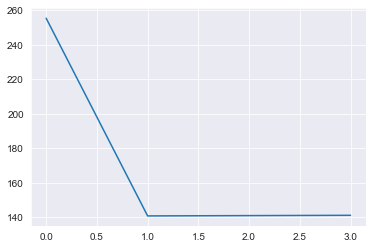

In [35]:
plt.plot([-mcmc1.get_samples()['log_lik'].mean(),
          -mcmc2.get_samples()['log_lik'].mean(),
          -mcmc3.get_samples()['log_lik'].mean(),
          -mcmc4.get_samples()['log_lik'].mean()])

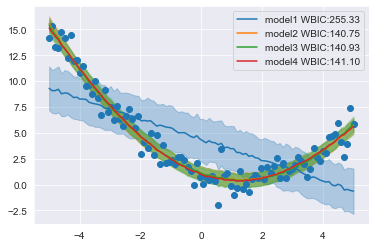

In [41]:
from numpyro.infer import Predictive
predictive = Predictive(model1, mcmc1.get_samples())
predict_samples = predictive(random.PRNGKey(0), x=x_data10, y=y_data10, y_obs=None, N=100)
mean = predict_samples['obs'].mean(axis=0)
low, high = jnp.percentile(predict_samples['obs'], jnp.array([25,75]), axis=0)
plt.plot(x_data10, y_data10, "o")
plt.plot(x_data10, mean, "C0", label=f'model1 WBIC:{-mcmc1.get_samples()["log_lik"].mean():3.2f}')
plt.fill_between(x_data10, y1=low, y2=high, color='C0', alpha=0.3)
#plt.fill_between(x_data10, low, high, "r", alpha=0.3)

predictive = Predictive(model2, mcmc2.get_samples())
predict_samples = predictive(random.PRNGKey(0), x=x_data10, y=y_data10, y_obs=None, N=100)
mean = predict_samples['obs'].mean(axis=0)
low, high = jnp.percentile(predict_samples['obs'], jnp.array([25,75]), axis=0)
plt.plot(x_data10, mean, "C1", label=f'model2 WBIC:{-mcmc2.get_samples()["log_lik"].mean():3.2f}')
plt.fill_between(x_data10, y1=low, y2=high, color='C1', alpha=0.3)
#plt.fill_between(x_data10, low, high, "r", alpha=0.3)

predictive = Predictive(model3, mcmc3.get_samples())
predict_samples = predictive(random.PRNGKey(0), x=x_data10, y=y_data10, y_obs=None, N=100)
mean = predict_samples['obs'].mean(axis=0)
low, high = jnp.percentile(predict_samples['obs'], jnp.array([25,75]), axis=0)
plt.plot(x_data10, mean, "C2", label=f'model3 WBIC:{-mcmc3.get_samples()["log_lik"].mean():3.2f}')
plt.fill_between(x_data10, y1=low, y2=high, color='C2', alpha=0.3)
#plt.fill_between(x_data10, low, high, "r", alpha=0.3)

predictive = Predictive(model4, mcmc4.get_samples())
predict_samples = predictive(random.PRNGKey(0), x=x_data10, y=y_data10, y_obs=None, N=100)
mean = predict_samples['obs'].mean(axis=0)
low, high = jnp.percentile(predict_samples['obs'], jnp.array([25,75]), axis=0)
plt.plot(x_data10, mean, "C3", label=f'model4 WBIC:{-mcmc4.get_samples()["log_lik"].mean():3.2f}')
plt.fill_between(x_data10, y1=low, y2=high, color='C2', alpha=0.3)

plt.legend()

確かに、WBIC:140.75でmodel2が選択できることがわかる